In [1]:
# import Libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, recall_score,
                             precision_recall_fscore_support, classification_report, confusion_matrix)
from sklearn.model_selection import GridSearchCV


In [2]:
# Load dataset

df = pd.read_csv('Q1_Dataset.csv')
#df.head()

In [3]:
# Train / Test split

# X = features, y = target
X = df[["x1", "x2"]]
y = df["true_label"]  # class labels: 0,1,2

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,  # fixed seed for reproducibility
    stratify=y  # preserves class proportions
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts(normalize=True).sort_index())
print("Test class distribution:\n", y_test.value_counts(normalize=True).sort_index())

Train shape: (315, 2)  Test shape: (135, 2)
Train class distribution:
 true_label
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64
Test class distribution:
 true_label
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64


In [4]:
## IMPLEMENT FOR LOGREG
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(

        max_iter=1000,
        random_state=42
    ))
])

logreg.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not wo

In [5]:

knn = Pipeline([
    ("scaler", StandardScaler()),  # important for distance-based models
    ("model", KNeighborsClassifier(
        n_neighbors=5,
        weights="distance"
    ))
])

knn.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",

In [6]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [7]:
models = {
    "Logistic Regression": logreg,
    "kNN": knn,
    "Random Forest": rf
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc
    })

# print(f"\n{name}")
# print("-" * len(name))
# print("Accuracy:", round(acc, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Summary table
results_df = pd.DataFrame(results)
results_df



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       0.93      0.91      0.92        45
           2       0.91      0.91      0.91        45

    accuracy                           0.93       135
   macro avg       0.93      0.93      0.93       135
weighted avg       0.93      0.93      0.93       135

Confusion Matrix:
[[44  1  0]
 [ 0 41  4]
 [ 2  2 41]]


,Model,Accuracy
0,Logistic Regression,0.948148
1,kNN,0.940741
2,Random Forest,0.933333


## PART C: Fine-tuning the selected algorithms

In [8]:
# Fine tuned LogReg


logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_param_grid = {
    "model__C": [0.01, 0.1, 1, 10, 100]
}

logreg_grid = GridSearchCV(
    logreg_pipe,
    logreg_param_grid,
    cv=5,
    scoring="accuracy"
)

logreg_grid.fit(X_train, y_train)

logreg_best = logreg_grid.best_estimator_
logreg_grid.best_params_, logreg_grid.best_score_


({'model__C': 0.1}, np.float64(0.9746031746031745))

In [9]:
## fine-tuning for KNN

knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier())
])

knn_param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11],
    "model__weights": ["uniform", "distance"]
}

knn_grid = GridSearchCV(
    knn_pipe,
    knn_param_grid,
    cv=5,
    scoring="accuracy"
)

knn_grid.fit(X_train, y_train)

knn_best = knn_grid.best_estimator_
knn_grid.best_params_, knn_grid.best_score_


({'model__n_neighbors': 5, 'model__weights': 'uniform'},
 np.float64(0.9777777777777776))

In [10]:
## fine-tuned Random Forest


rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    cv=5,
    scoring="accuracy"
)

rf_grid.fit(X_train, y_train)

rf_best = rf_grid.best_estimator_
rf_grid.best_params_, rf_grid.best_score_


({'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100},
 np.float64(0.980952380952381))

## PART D: Evaluation of The Fine-tuned Models
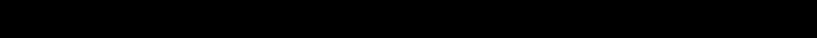
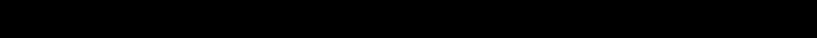

In [21]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
)

models = {
    "Logistic Regression": logreg_best,
    "kNN": knn_best,
    "Random Forest": rf_best
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")

    precision, recall, _, _ = precision_recall_fscore_support(
        y_test, y_pred, labels=[0, 1, 2]
    )

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Macro F1" : f1_macro,
        "Precision (Class 0)": precision[0],
        "Recall (Class 0)": recall[0],
        "Precision (Class 1)": precision[1],
        "Recall (Class 1)": recall[1],
        "Precision (Class 2)": precision[2],
        "Recall (Class 2)": recall[2],
    })


comparison_df = pd.DataFrame(results).round(4)
comparison_df


,Model,Accuracy,Macro F1,Precision (Class 0),Recall (Class 0),Precision (Class 1),Recall (Class 1),Precision (Class 2),Recall (Class 2)
0,Logistic Regression,0.9556,0.9556,0.9778,0.9778,0.9545,0.9333,0.9348,0.9556
1,kNN,0.9407,0.9407,0.9778,0.9778,0.9318,0.9111,0.9130,0.9333
2,Random Forest,0.9333,0.9332,0.9565,0.9778,0.9318,0.9111,0.9111,0.9111


## Evaluating confusion Matrices for all Models

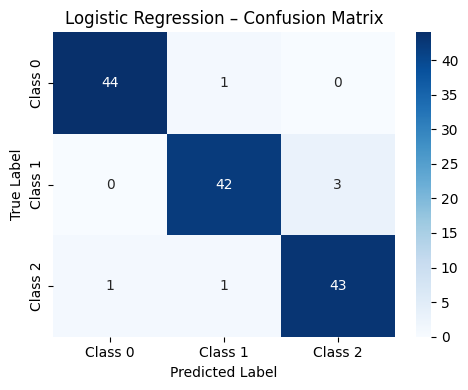

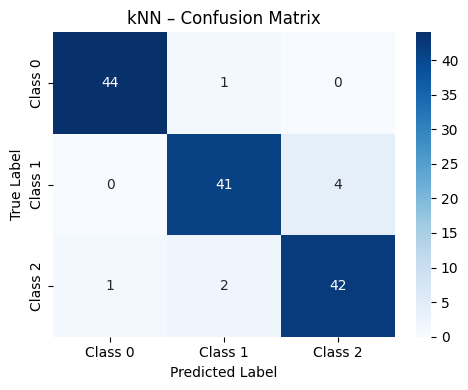

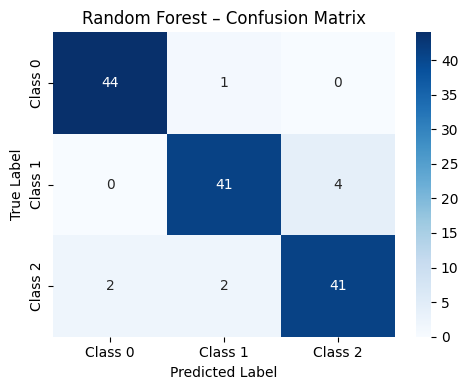

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ["Class 0", "Class 1", "Class 2"]

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{name} – Confusion Matrix")
    plt.tight_layout()
    plt.show()


## Q2 – Part E: Decision Boundaries and Model Behavior
### Plot Decision Boundaries with Train/Test Points

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X_train, y_train, X_test, y_test, title):
    # Convert to numpy
    X_tr = X_train.values
    X_te = X_test.values

    # Mesh grid
    x_min, x_max = X_tr[:, 0].min() - 1, X_tr[:, 0].max() + 1
    y_min, y_max = X_tr[:, 1].min() - 1, X_tr[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y_train, marker="o", label="Train")
    plt.scatter(X_te[:, 0], X_te[:, 1], c=y_test, marker="x", label="Test")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()


C:\Users\Administrator\PycharmProjects\DataAnalyticsFinalExams\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


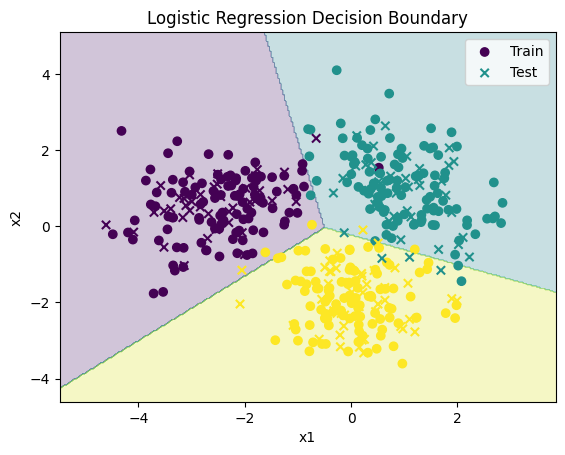

In [18]:
## Desion Boundary for LogReg

plt.figure()
plot_decision_boundary(
    logreg_best,
    X_train, y_train,
    X_test, y_test,
    "Logistic Regression Decision Boundary"
)
plt.show()


C:\Users\Administrator\PycharmProjects\DataAnalyticsFinalExams\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


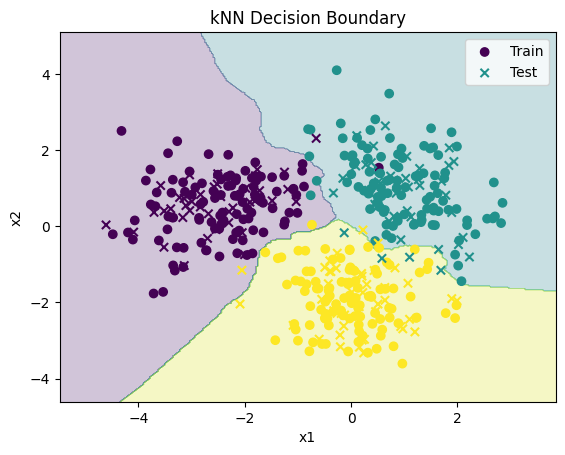

In [19]:
## Decison Boundary for KNN

plt.figure()
plot_decision_boundary(
    knn_best,
    X_train, y_train,
    X_test, y_test,
    "kNN Decision Boundary"
)
plt.show()


C:\Users\Administrator\PycharmProjects\DataAnalyticsFinalExams\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


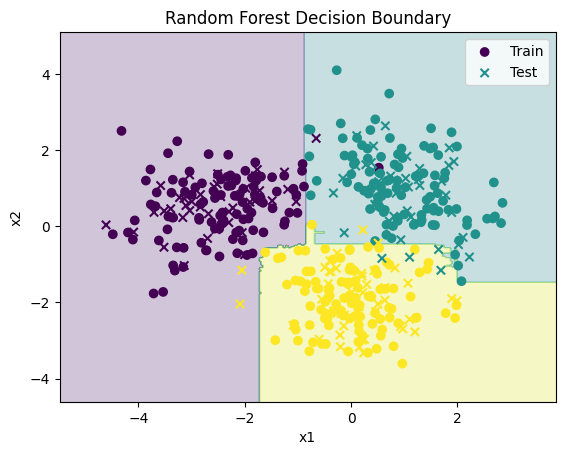

In [20]:
## Decision Boundary for RF

plt.figure()
plot_decision_boundary(
    rf_best,
    X_train, y_train,
    X_test, y_test,
    "Random Forest Decision Boundary"
)
plt.show()
